# ML Cup Notebook

In [1]:
from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model.network import NeuralNetwork
from model.trainer import Trainer
from model.losses import Loss, mee
from utils import DataLoader
from utils import plot_curves
from utils import StandardScaler
from utils.model_selection_helpers import instability_coeff, tran_val_diff, count_parameters
from utils.grid_search import grid_search_mlcup
import copy
from IPython.display import clear_output

np.random.seed(8) # for reproducibility, we are not choosing a 'good seed for rigging experiments', just my lucky number =)

In [2]:
# Load Data
PATH = 'data/ML CUP/ML-CUP25-TR.csv'
df = pd.read_csv(PATH, comment='#', header=None)

dataset = np.array(df)
X = dataset[:, 1:-4]
y = dataset[:, -4:]

print(f"X.shape: {X.shape}, y.shape: {y.shape} ")
train_test_dataset = DataLoader(X, y)
X_train, y_train, X_test, y_test = train_test_dataset.train_val_split(portion = 0.8, shuffle = True)
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}, X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")

X.shape: (500, 12), y.shape: (500, 4) 
X_train.shape: (400, 12), y_train.shape: (400, 4), X_test.shape: (100, 12), y_test.shape: (100, 4)


## Grid search has been carryed on the other notebook
We have chosen 4 single output neural networks instead of 1 4-output neural network
### These are the chosen hyperparameters for each one of the 4 neural networks
### y_0:
Config index: ([12, 16, 16, 1], ['tanh', 'tanh', 'identity'], 'mse', 0.0001, 0, 0.9, 16), Avg Epochs: 206, Mean MEE: 6.958706829910436
### y_1:
Config index: ([12, 32, 32, 32, 1], ['leaky relu', 'leaky relu', 'leaky relu', 'identity'], 'mse', 0.0001, 0, 0.9, 32), Avg Epochs: 237, Mean MEE: 8.186459422340059, Mean Epochs: 237,
### y_2:
Config index: ([12, 32, 32, 1], ['leaky relu', 'leaky relu', 'identity'], 'mse', 0.001, 0.0001, 0.5, 16), Avg Epochs: 105, Mean MEE: 10.84948787794317, Mean Epochs: 105,
### y_3:
Config index: ([12, 32, 1], ['relu', 'identity'], 'mse', 0.0001, 0, 0.5, 32), Avg Epochs: 134, Mean MEE: 10.845442072403333, Mean Epochs: 134,

In [3]:
# Best MEE nn > sqrt (n0 ** 2 + n1 ** 2 + n2 ** 2 + n3 ** 2) 
print(f"best mme of the NN with 4 outputs is 20.95 (best of grid search), best mme of the 4 NNs with 1 output is {(7 ** 2 + 8.5 ** 2 + 11 ** 2 + 11 ** 2) ** 0.5} (each nn extimation is the min mae we consider in choosing the architecture)")

best mme of the NN with 4 outputs is 20.95 (best of grid search), best mme of the 4 NNs with 1 output is 19.059118552545918 (each nn extimation is the min mae we consider in choosing the architecture)


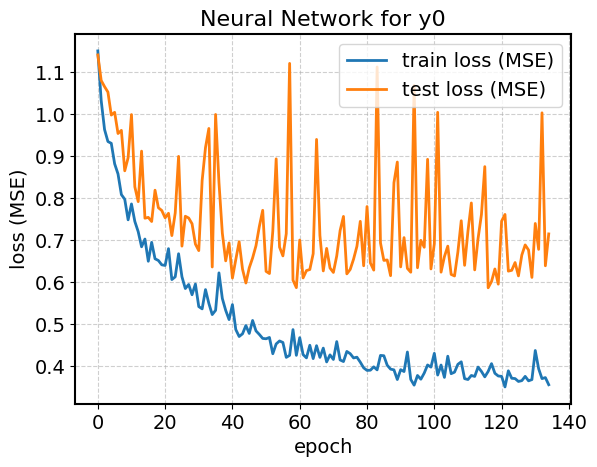

Train MAE for y0: 6.1927786719473765
Test MAE for y0: 8.197493336993123


In [18]:
# y0
y0_train = np.reshape(y_train[:, [0]], (-1, 1))
y0_test = np.reshape(y_test[:, [0]], (-1, 1))

### chosen configuration
'''Config index: ([12, 16, 16, 1], ['tanh', 'tanh', 'identity'], 'mse', 0.001, 1e-06, 0.5, 16), Avg Epochs: 185, Mean MEE: 6.800723930727736%,
            training instability coeff validation: 12.685045247437285, 
            training instability coeff train: 4.611673796135477, 
            training loss-val loss diff: 17.884921268460808, 
            Mean Epochs: 185,
            Mean Test Loss (not rescaled): 0.41188370445953215,
            Std Test Loss (not rescaled): 0.06452958679154754
'''

# Choose the best configuration and train it on the full training set, evaluate on the test set
NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE = [12, 16, 16, 1], ['tanh', 'tanh', 'identity'], 'mse', 0.001, 1e-06, 0.5, 16
EPOCHS = 185 - 50 # we reduce by patience

#scaling
X_scaler = StandardScaler(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_val_scaled = X_scaler.transform(X_test)
y_scaler = StandardScaler(y0_train)
y_train_scaled = y_scaler.transform(y0_train)
y_val_scaled = y_scaler.transform(y0_test)

#training
nn = NeuralNetwork(NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION)
trainer = Trainer(
    nn=nn,
    loss=Loss(LOSS_F),
    X_train=X_train_scaled,
    y_train=y_train_scaled,
    X_val = X_val_scaled,
    y_val=y_val_scaled,
    epochs=EPOCHS,
    early_stopping=EPOCHS + 1, #can't early stop because we are using the test set as final evaluation, the +1 is to be extra sure
    eta=ETA,                   # Learning rate iniziale
    lam=LAMBDA,                # L2
    alpha=ALPHA,               # Momentum
    batch_size=BATCH_SIZE,
    shuffle_batches=True
)
# still returns the best nn, but we don-t use it for accuracy calculation nor early stopping otherwise it is data leakage
best_nn, train_loss_vector, test_loss_vector = trainer.train(print_epochs=False)

#plot curves
plot_curves(np.array(train_loss_vector), np.array(test_loss_vector), 'loss (MSE)', 'test', title = 'Neural Network for y0', save_plots=True)

# Train MAE
out = nn.forward(X_train_scaled)[-1][-1] 
out = y_scaler.inverse_transform(out)
train_loss = mee(y0_train, out)
print(f"Train MAE for y0: {np.mean(train_loss)}")

# Test MAE
out = nn.forward(X_val_scaled)[-1][-1]  #have to use the last trained nn, otherwise is data leakage
out = y_scaler.inverse_transform(out)

test_loss = mee(y0_test, out)
print(f"Test MAE for y0: {np.mean(test_loss)}")

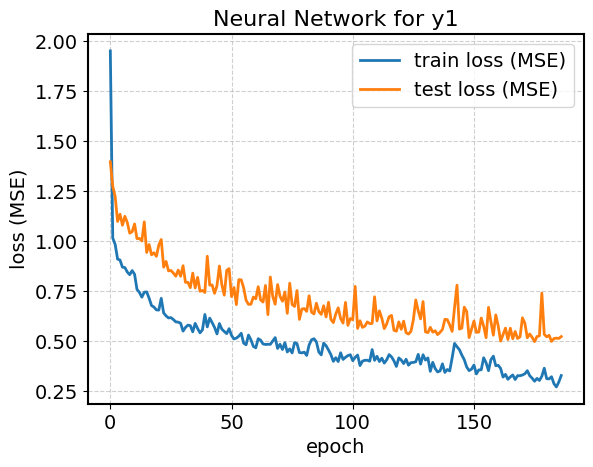

Train MAE for y1: 5.813251677442039
Test MAE for y1: 7.9404802590395125


In [15]:
# y1
y1_train = np.reshape(y_train[:, [1]], (-1, 1))
y1_test = np.reshape(y_test[:, [1]], (-1, 1))

### chosen configuration
'''Config index: ([12, 32, 32, 32, 1], ['leaky relu', 'leaky relu', 'leaky relu', 'identity'], 'mse', 0.0001, 0, 0.9, 32), Avg Epochs: 237, Mean MEE: 8.186459422340059%,
            training instability coeff validation: 12.011839176584978, 
            training instability coeff train: 7.045989416517777, 
            training loss-val loss diff: 58.54844678935999, 
            Mean Epochs: 237,
            Mean Test Loss (not rescaled): 0.5751684639454956,
            Std Test Loss (not rescaled): 0.09357310387412392
'''

# Choose the best configuration and train it on the full training set, evaluate on the test set
NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE = [12, 32, 32, 32, 1], ['leaky relu', 'leaky relu', 'leaky relu', 'identity'], 'mse', 0.0001, 0, 0.9, 32
EPOCHS = 237 - 50 # we reduce by 50% of patience by reducing overfitting but allowing convergence

#scaling
X_scaler = StandardScaler(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_val_scaled = X_scaler.transform(X_test)
y_scaler = StandardScaler(y1_train)
y_train_scaled = y_scaler.transform(y1_train)
y_val_scaled = y_scaler.transform(y1_test)

#training
nn = NeuralNetwork(NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION)
trainer = Trainer(
    nn=nn,
    loss=Loss(LOSS_F),
    X_train=X_train_scaled,
    y_train=y_train_scaled,
    X_val = X_val_scaled,
    y_val=y_val_scaled,
    epochs=EPOCHS,
    early_stopping=EPOCHS + 1, #can't early stop because we are using the test set as final evaluation, the +1 is to be extra sure
    eta=ETA,                   # Learning rate iniziale
    lam=LAMBDA,                # L2
    alpha=ALPHA,               # Momentum
    batch_size=BATCH_SIZE,
    shuffle_batches=True
)
# still returns the best nn, but we don-t use it for accuracy calculation nor early stopping otherwise it is data leakage
best_nn, train_loss_vector, test_loss_vector = trainer.train(print_epochs=False)

#plot curves
plot_curves(np.array(train_loss_vector), np.array(test_loss_vector), 'loss (MSE)', 'test', title = 'Neural Network for y1', save_plots=True)
# Train MAE
out = nn.forward(X_train_scaled)[-1][-1] 
out = y_scaler.inverse_transform(out)
train_loss = mee(y1_train, out)
print(f"Train MAE for y1: {np.mean(train_loss)}")

# Test MAE
out = nn.forward(X_val_scaled)[-1][-1]  #have to use the last trained nn, otherwise is data leakage
out = y_scaler.inverse_transform(out)

test_loss = mee(y1_test, out)
print(f"Test MAE for y1: {np.mean(test_loss)}")

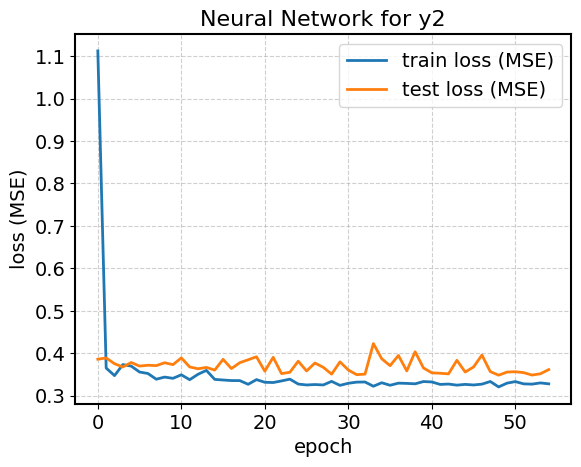

Train MAE for y2: 10.982014089712207
Test MAE for y2: 11.291064971834878


In [6]:
# y2
y2_train = np.reshape(y_train[:, [2]], (-1, 1))
y2_test = np.reshape(y_test[:, [2]], (-1, 1))

### chosen configuration
'''Config index: ([12, 32, 32, 1], ['leaky relu', 'leaky relu', 'identity'], 'mse', 0.001, 0.0001, 0.5, 16), Avg Epochs: 105, Mean MEE: 10.84948787794317%,
            training instability coeff validation: 2.5292733759189554, 
            training instability coeff train: 1.010538024604252, 
            training loss-val loss diff: 4.239784219939396, 
            Mean Epochs: 105,
            Mean Test Loss (not rescaled): 0.3379247113818994,
            Std Test Loss (not rescaled): 0.034564167893114776
'''

# Choose the best configuration and train it on the full training set, evaluate on the test set
NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE = [12, 32, 32, 1], ['leaky relu', 'leaky relu', 'identity'], 'mse', 0.001, 0.0001, 0.5, 16
EPOCHS = 105 - 50 # we reduce by 50% of patience by reducing overfitting but allowing convergence

#scaling
X_scaler = StandardScaler(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_val_scaled = X_scaler.transform(X_test)
y_scaler = StandardScaler(y2_train)
y_train_scaled = y_scaler.transform(y2_train)
y_val_scaled = y_scaler.transform(y2_test)

#training
nn = NeuralNetwork(NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION)
trainer = Trainer(
    nn=nn,
    loss=Loss(LOSS_F),
    X_train=X_train_scaled,
    y_train=y_train_scaled,
    X_val = X_val_scaled,
    y_val=y_val_scaled,
    epochs=EPOCHS,
    early_stopping=EPOCHS + 1, #can't early stop because we are using the test set as final evaluation, the +1 is to be extra sure
    eta=ETA,                   # Learning rate iniziale
    lam=LAMBDA,                # L2
    alpha=ALPHA,               # Momentum
    batch_size=BATCH_SIZE,
    shuffle_batches=True
)
# still returns the best nn, but we don-t use it for accuracy calculation nor early stopping otherwise it is data leakage
best_nn, train_loss_vector, test_loss_vector = trainer.train(print_epochs=False)

#plot curves
plot_curves(np.array(train_loss_vector), np.array(test_loss_vector), 'loss (MSE)', 'test', title = 'Neural Network for y2', save_plots=True)
# Train MAE
out = nn.forward(X_train_scaled)[-1][-1] 
out = y_scaler.inverse_transform(out)
train_loss = mee(y2_train, out)
print(f"Train MAE for y2: {np.mean(train_loss)}")

# Test MAE
out = nn.forward(X_val_scaled)[-1][-1]  #have to use the last trained nn, otherwise is data leakage
out = y_scaler.inverse_transform(out)

test_loss = mee(y2_test, out)
print(f"Test MAE for y2: {np.mean(test_loss)}")

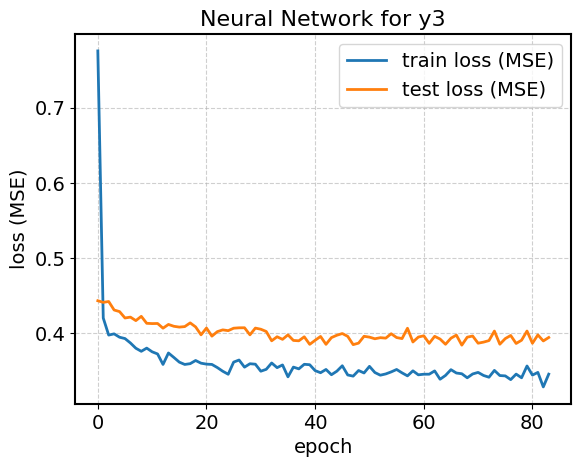

Train MAE for y3: 10.632886318373517
Test MAE for y3: 11.66491725690454


In [7]:
# y3
y3_train = np.reshape(y_train[:, [3]], (-1, 1))
y3_test = np.reshape(y_test[:, [3]], (-1, 1))

### chosen configuration
'''Config index: ([12, 32, 1], ['relu', 'identity'], 'mse', 0.0001, 0, 0.5, 32), Avg Epochs: 134, Mean MEE: 10.845442072403333%,
            training instability coeff validation: 1.0874747729680092, 
            training instability coeff train: 0.3703699933258762, 
            training loss-val loss diff: 9.949704536579532, 
            Mean Epochs: 134,
            Mean Test Loss (not rescaled): 0.3591474812280584,
            Std Test Loss (not rescaled): 0.08642917030494307
'''

# Choose the best configuration and train it on the full training set, evaluate on the test set
NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE = [12, 32, 1], ['relu', 'identity'], 'mse', 0.0001, 0, 0.5, 32
EPOCHS = 134 - 50 # we reduce by 50% of patience by reducing overfitting but allowing convergence

#scaling
X_scaler = StandardScaler(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_val_scaled = X_scaler.transform(X_test)
y_scaler = StandardScaler(y3_train)
y_train_scaled = y_scaler.transform(y3_train)
y_val_scaled = y_scaler.transform(y3_test)

#training
nn = NeuralNetwork(NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION)
trainer = Trainer(
    nn=nn,
    loss=Loss(LOSS_F),
    X_train=X_train_scaled,
    y_train=y_train_scaled,
    X_val = X_val_scaled,
    y_val=y_val_scaled,
    epochs=EPOCHS,
    early_stopping=EPOCHS + 1, #can't early stop because we are using the test set as final evaluation, the +1 is to be extra sure
    eta=ETA,                   # Learning rate iniziale
    lam=LAMBDA,                # L2
    alpha=ALPHA,               # Momentum
    batch_size=BATCH_SIZE,
    shuffle_batches=True
)
# still returns the best nn, but we don-t use it for accuracy calculation nor early stopping otherwise it is data leakage
best_nn, train_loss_vector, test_loss_vector = trainer.train(print_epochs=False)

#plot curves
plot_curves(np.array(train_loss_vector), np.array(test_loss_vector), 'loss (MSE)', 'test', title = 'Neural Network for y3', save_plots=True)
# Train MAE
out = nn.forward(X_train_scaled)[-1][-1] 
out = y_scaler.inverse_transform(out)
train_loss = mee(y3_train, out)
print(f"Train MAE for y3: {np.mean(train_loss)}")

# Test MAE
out = nn.forward(X_val_scaled)[-1][-1]  #have to use the last trained nn, otherwise is data leakage
out = y_scaler.inverse_transform(out)

test_loss = mee(y3_test, out)
print(f"Test MAE for y3: {np.mean(test_loss)}")

# Last Train for ML CUP competition